In [1]:
# !wget https://github.com/Phonbopit/sarabun-webfont/blob/master/fonts/thsarabunnew-webfont.ttf

In [2]:
import matplotlib
print(matplotlib.get_configdir())

/Users/witchaphol.ru/.matplotlib


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import pandas as pd
import shap, random

In [4]:
plt.rcParams['font.family'] = 'Sarabun'

#### Read Data

In [5]:
df = pd.read_csv('Smartphone_Survey.csv')
df.rename(columns={
  'Timestamp': 'timestamp',
  'เพศของผู้ตอบแบบสอบถาม': 'gender',
  'ช่วงอายุของผู้ตอบแบบสอบถาม': 'age',
  'อาชีพของผู้ตอบแบบสอบถาม': 'job_type',
  'ช่วงเงินเดือนของผู้ตอบแบบสอบถาม': 'salary',
  'ปัจจุบันท่านใช้สมาร์ทโฟนระบบปฎิบัติการใด': 'current_os',
  'ท่านใช้สมาร์ทโฟนในการทำอะไรมากที่สุด [เล่นเกม]': 'cat_game',
  'ท่านใช้สมาร์ทโฟนในการทำอะไรมากที่สุด [เล่นโซเชี่ยลมีเดีย]': 'cat_social_media',
  'ท่านใช้สมาร์ทโฟนในการทำอะไรมากที่สุด [ดูหนัง ฟังเพลง]': 'cat_movie_music',
  'ท่านใช้สมาร์ทโฟนในการทำอะไรมากที่สุด [ถ่ายรูป ถ่ายวิดีโอ]': 'cat_photo_video',
  'หากท่านซื้อสมาร์ทโฟนเครื่องใหม่ จะใช้เลือกซื้อสมาร์ทโฟนแบรนด์ใด': 'preferred_phone',
  'จากข้อที่แล้ว เนื่องจากสาเหตุใด': 'preferred_phone_reasons'
}, inplace=True)
df.drop(columns=['timestamp', 'preferred_phone_reasons'], inplace=True)

LE: [cat_game, cat_game, cat_movie_music, cat_photo_video]  
One-hot: [gender, age, job, salary, os, preferred_phone]  

#### Label Encoding

In [6]:
LE = LabelEncoder()
for col in ['cat_game', 'cat_social_media', 'cat_movie_music', 'cat_photo_video', 'current_os']:
  df[col] = LE.fit_transform(df[col])

#### One-hot Encoding

In [7]:
df = pd.get_dummies(df, columns=['gender', 'age', 'job_type', 'salary', 'preferred_phone'])

#### Train-Test Split

In [8]:
X = df
y = df['current_os']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22004)
X_train = X_train.astype(int)
X_test = X_test.astype(int)

X_test_ori = X_test.copy()
X_train.drop(columns='current_os', inplace=True)
X_test.drop(columns='current_os', inplace=True)

#### Train Model

In [9]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

#### Feature Importance

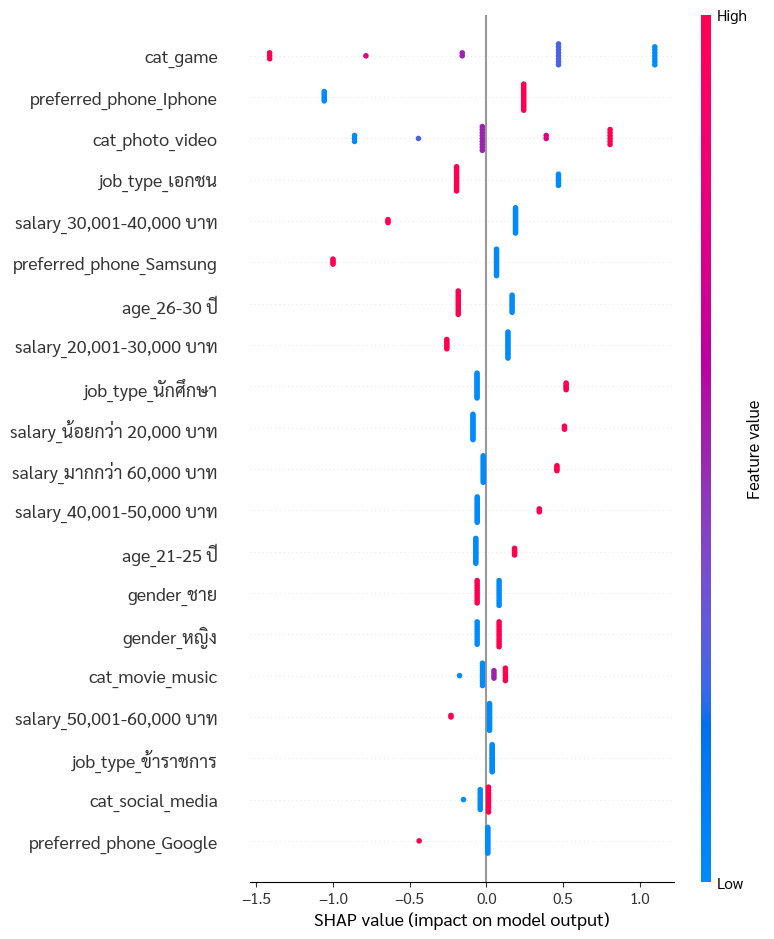

In [10]:
explainer = shap.LinearExplainer(model, X_train, feature_purturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot")
plt.show()

#### Analyse Sample

Sample:
current_os: 1
cat_game: 1
cat_social_media: 2
cat_movie_music: 3
cat_photo_video: 2
gender_ชาย: 1
age_36-40 ปี: 1
job_type_เอกชน: 1
salary_มากกว่า 60,000 บาท: 1
preferred_phone_Iphone: 1


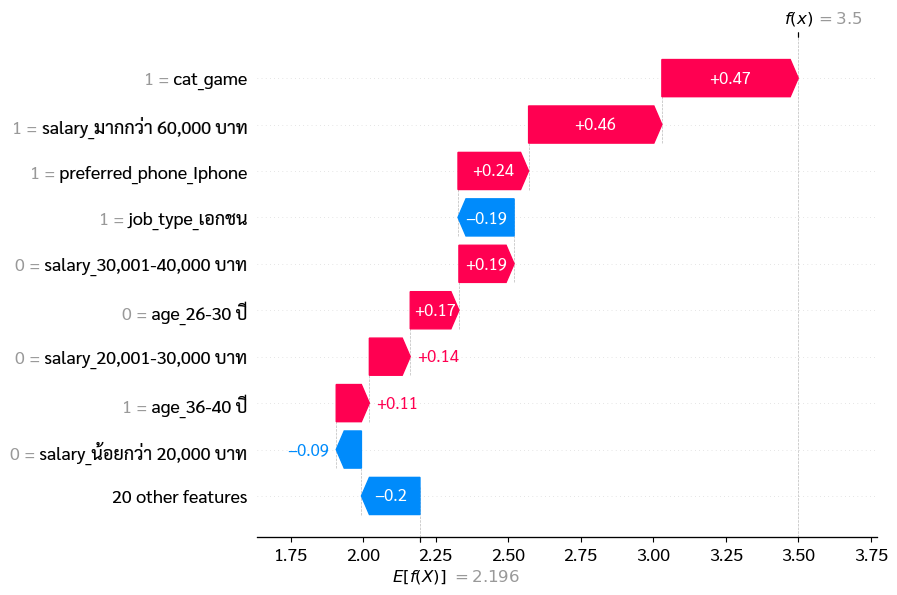


Prediction: [1]


In [12]:
random.seed(22004)
random_index = random.randint(0, len(X_test_ori) - 1)
sample = X_test_ori.iloc[random_index:random_index+1].copy()

print("Sample:")
for col in sample.columns:
  if 'gender_' in col or 'age_' in col or 'job_type_' in col or 'salary_' in col or 'preferred_phone_' in col:
    if sample.iloc[0][col] == 1:
      print(f"{col}: {sample.iloc[0][col]}")
  else:
    print(f"{col}: {sample.iloc[0][col]}")

sample.drop(columns='current_os', inplace=True)
shap_values_sample = explainer.shap_values(sample)
shap.waterfall_plot(shap.Explanation(
  values=shap_values_sample[0]
  , base_values=explainer.expected_value
  , data=sample.iloc[0]
))

print()
print("Prediction:", model.predict(sample))